In [1]:
# Import libraries
import os
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import pymc as pm
from scipy.special import expit, logit
import json
import matplotlib.pyplot as plt

# Set up visualization style and context
sns.set_style("ticks")
sns.set_context('paper', font_scale=1.25)

# Create directory if it does not exist
def make_dir(newpath):
    if not os.path.exists(newpath):
        os.makedirs(newpath)

make_dir('./out/tables/')
make_dir('./out/figs/')
make_dir('./out/figs/manuscript/')
make_dir('./out/figs/individual/')

# Define a dictionary of functions for arviz's summary function
func_dict = {
    "std": np.std,
    "1.5%": lambda x: np.percentile(x, 1.5),
    "3%": lambda x: np.percentile(x, 3),
    "25%": lambda x: np.percentile(x, 25),
    "median": lambda x: np.percentile(x, 50),
    "75%": lambda x: np.percentile(x, 75),
    "97%": lambda x: np.percentile(x, 97),
    "98.5%": lambda x: np.percentile(x, 98.5),
}



# Load parameters from a JSON file
params = json.load(open('./params.json', 'r'))

# Configure notebook settings
%matplotlib inline
%load_ext autoreload
%autoreload 2

#Load Dataset
df = pd.read_csv('./dat/data63.csv')
df_adj = pd.read_excel('./dat/data63_adj.xlsx')


# Load Data and Models

In [5]:
from src.models import get_belief_model, get_share_model, get_WEPT_model, get_policy_model
df['Country'] = df['country']
az.rcParams["data.load"] = 'eager'
idata_belief = az.from_netcdf('./out/posteriors/belief.nc')
belief_model, belief_df, belief_long = get_belief_model(df, priors = params['belief']['priors'],)

In [6]:
idata_policy = az.from_netcdf('./out/posteriors/policy.nc')
policy_model, policy_df = get_policy_model(df_adj)

/home/jbb2191/github/ManyLabsClimate/src/models.py:47: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_policy = df_policy.groupby(["UniqueID", "Country", "condName", "BeliefADJ"]).mean().reset_index()


In [7]:
share_model, share_df, _ = get_share_model(df_adj, priors = params['share']['priors'])
share_idata = az.from_netcdf('./out/posteriors/share.nc')

In [8]:
wept_model, wept_df = get_WEPT_model(df_adj, priors=params['wept']['priors'])
wept_idata = az.from_netcdf('./out/posteriors/wept.nc')

# Country Analysis

## Calculate Country-Level marginal posteriors

/tmp/ipykernel_161911/994108108.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(average_study_belief)


<Axes: ylabel='Density'>

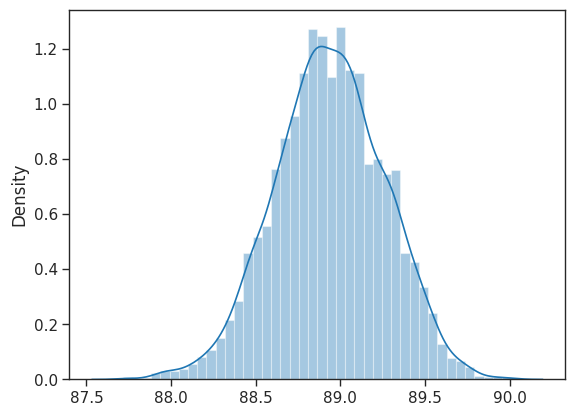

In [10]:
#Define average belief
theta_belief = expit(idata_belief.posterior['alpha_theta'] + idata_belief.posterior['beta_theta']  * idata_belief.posterior['a'])
average_study_belief = 100*(theta_belief + (1-theta_belief) * expit(idata_belief.posterior['a']))
sns.distplot(average_study_belief)

### Belief

In [11]:
#Function to remove unnecessary formatting around names. 
strip_excess = np.vectorize(lambda x: x[8:-1])
#Summarize belief by country, and sort by mean in the linear space
country_summary = az.summary(idata_belief.posterior['country']).sort_values('mean',ascending=False)
belief_labels = strip_excess(country_summary.index.values)
#Get the mean of the linear belief space. 
country_mu  = idata_belief.posterior['country'].sel({'countries':strip_excess(country_summary.index.values)})
#Calculate the probability that 1 is selected, given the mean of the linear space.
country_plot_data = 100 * ( expit(country_mu) )
country_mean = country_plot_data.mean(dim='countries')


### Policy


In [12]:
#Function to remove unnecessary formatting around names.
strip_excess = np.vectorize(lambda x: x[2:-1])
#Identify the index of the control group
ctrl_idx = np.where(idata_policy.posterior['u_t'].coords['treatments']=='Control')[0][0]

policy_country =  idata_policy.posterior['Alpha'] + idata_policy.posterior['u_c'][:,:,0,:] + \
                    idata_policy.posterior['u_t'][:,:,ctrl_idx, 0] + \
                    (idata_policy.posterior['u_t'][:,:,ctrl_idx, 1]+ \
                    idata_policy.posterior['u_c'][:,:,1, :]  + \
                    idata_policy.posterior['Beta'] )* logit(country_plot_data/100)
policy_country = 100*((1-idata_policy.posterior['theta']) * expit(policy_country) + \
                    idata_policy.posterior['theta'] * expit(idata_policy.posterior['tau_offset']* policy_country + policy_country))

#Summarize and sort              
country_summary = az.summary(policy_country).sort_values('mean',ascending=False)
#Get the labels for the countries
labels_policy = strip_excess(country_summary.index.values)
#map the table from the linear space to the % agreement space. 
plot_data_policy = policy_country.sel({'countries':strip_excess(country_summary.index.values)})
avg_policy = plot_data_policy.mean(dim='countries').data

### Sharing 

In [25]:

#Sharing 
#Function to remove unnecessary formatting around names.
strip_excess = np.vectorize(lambda x: x[2:-1]) 
#Calculate average sharing
#As with policy, we need to be careful that country-level belief is in logit/linear space
average_share = 100*expit(share_idata.posterior['Alpha'] + \
                   share_idata.posterior['Beta'] * logit(country_plot_data/100)+ \
                       share_idata.posterior['u_c'][:,:,0,:] + \
                           share_idata.posterior['u_c'][:,:,1,:] * logit(country_plot_data/100) )
#summarize and sort, then get the labels
share_country_summary = az.summary(average_share).sort_values('mean', ascending=False)
sharing_labels = strip_excess(share_country_summary.index.values)


In [95]:
plt.figure(figsize=(4, 8))


#WEPT
#Here we rely on posterior predictive summaries to get the mean and 95% CI for each country
#again we need belief in logit space for each country. 
belief_by_country = logit(country_plot_data.sel({'countries':wept_idata.posterior['countries']}).mean(dim=('chain', 'draw'))/100.0)

#Simulate country-level wept 
with wept_model:
    n_countries = wept_idata.posterior['countries'].data.size
    pm.set_data({'country_sim':np.arange(n_countries), 
                 'treatment_sim':np.repeat(np.where(wept_idata.posterior['treatments']=='Control')[0], n_countries), 
                 'sim_belief':belief_by_country,
                 'bool_country':np.repeat(1, n_countries)})
    ppc = pm.sample_posterior_predictive(wept_idata, var_names=['sim_mu'], random_seed=123)
ppc.posterior_predictive['sim_mu'].coords['sim_mu_dim_2'] = wept_idata.posterior['countries'].data

#Simulate average wept 
with wept_model:
    ctrl_idx = np.where(wept_idata.posterior['treatments']=='Control')[0][0]
    n_countries = wept_idata.posterior['countries'].data.size
    pm.set_data({'country_sim':np.array([0]),
                 'treatment_sim':np.array([ctrl_idx]), 
                 'sim_belief':[logit(np.mean(average_study_belief)).values],
                 'bool_country':np.array([0])})
    avg = pm.sample_posterior_predictive(wept_idata, var_names=['sim_mu'], random_seed=123)

#Function to remove unnecessary formatting around names.
strip_excess = np.vectorize(lambda x: x[7:-1])

#Get the mean and 95% CI for each country, sort, and get the labels
sorted = az.summary(ppc.posterior_predictive['sim_mu'])
sorted_raw_index = sorted.index
convert_dict = dict(zip(sorted_raw_index,  wept_idata.posterior['countries'].data))
sorted = sorted.sort_values('mean', ascending=False)
wept_ls = [convert_dict[item] for item in sorted.index]

#Get the mean and 95% CI for the average wept, make sure to sort the index to match the country labels
wept_plotting = ppc.posterior_predictive['sim_mu'].sel({'sim_mu_dim_2':strip_excess(sorted.index).astype('int')})
wept_mu = avg.posterior_predictive['sim_mu'].data


Sampling: []


Sampling: []


<xarray.DataArray 'sim_mu' (chain: 4, draw: 1000, sim_mu_dim_2: 63)>
array([[[7.58479673, 6.77828293, 6.31368744, ..., 2.92043075,
         2.89106314, 1.08229135],
        [6.19305185, 7.29099409, 6.88430208, ..., 3.5078187 ,
         3.01154345, 1.26791008],
        [6.9095888 , 7.3526749 , 6.9387662 , ..., 3.37945209,
         2.92869676, 1.67119487],
        ...,
        [6.14549773, 6.8952083 , 6.05223047, ..., 3.24726036,
         3.10249894, 1.46112295],
        [6.71676022, 6.64282888, 6.52727174, ..., 3.12423359,
         2.79641206, 1.49471061],
        [6.260394  , 6.54096806, 6.18404784, ..., 3.40532788,
         3.042668  , 1.46621687]],

       [[7.09051308, 6.53097194, 6.49408889, ..., 3.18941033,
         2.96472371, 1.35846851],
        [7.23474537, 6.57706092, 6.53284993, ..., 3.31082466,
         2.74597149, 1.78469378],
        [6.55908457, 6.51616207, 6.64191977, ..., 3.18553055,
         2.66205151, 1.45128569],
...
        [7.2887277 , 7.22123474, 7.28343218, ..., 3.06572117,
         3.14801241, 1.63301418],
        [6.57795396, 6.56438216, 7.46196222, ..., 3.37737452,
         2.68231711, 1.61611921],
        [6.59425448, 6.4365567 , 7.56937128, ..., 3.16466124,
         2.87996948, 1.4331472 ]],

       [[7.59204045, 7.63019881, 6.45831351, ..., 2.96134027,
         2.97226371, 1.72197849],
        [5.98701735, 6.94663231, 6.3393056 , ..., 3.44436141,
         2.89845131, 1.15322315],
        [7.51091468, 7.09295022, 6.5938255 , ..., 3.0816275 ,
         2.95501152, 1.98336063],
        ...,
        [7.09210907, 6.27356405, 6.24795205, ..., 3.21394086,
         2.90238759, 1.43002615],
        [6.23601216, 6.89642223, 6.30446272, ..., 3.30304945,
         3.01302695, 1.47833194],
        [6.71574096, 6.91432201, 6.6210404 , ..., 3.30319309,
         2.78925834, 1.33899444]]])
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * sim_mu_dim_2  (sim_mu_dim_2) int64 25 41 61 35 9 43 23 ... 44 14 2 21 20 52

<Figure size 400x800 with 0 Axes>


## Plotting Country Figure

/tmp/ipykernel_161911/589118805.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


<Figure size 800x400 with 0 Axes>

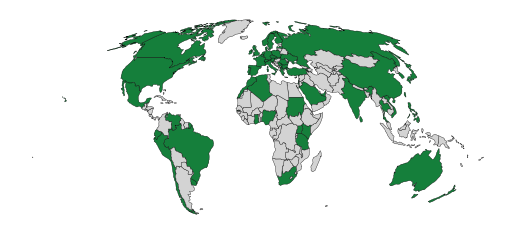

In [89]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import geopandas
strip_excess = np.vectorize(lambda x: x[8:-1])

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
crs = ccrs.Mollweide()



# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
world = world.to_crs(crs_proj4)

#crop the world map to the extent of the data
a = world.cx[world.bounds.minx.min()*.8:world.bounds.maxx.max()*.8, world.bounds.miny.min():world.bounds.maxy.max()]

# Define the CartoPy CRS object.
crs = ccrs.Mollweide()




#Function for fixing renamed country data
def fix_df_countries(data, column='name'):
    data[column] = data[column].str.capitalize()
    conversion_dict = {'Russian Federation':'Russia',
                    'United arab emirates':'United Arab Emirates',
                    'uk':'United Kingdom',
                    'South korea':'South Korea',
                    'North macedonia':'North Macedonia',
                    'South africa':'South Africa',
                    'Saudi arabia': 'Saudi Arabia',
                    'Sri lanka': 'Sri Lanka',
                    'Newzealand': 'New Zealand',
                    'New zealand': 'New Zealand',
                    'usa': 'United States of America',
                    'Unitedarabemirates': 'United Arab Emirates',
                    'Southafrica': 'South Africa',
                    'Northmacedonia': 'North Macedonia',
                    'Southkorea': 'South Korea',
                    'Srilanka': 'Sri Lanka',
                    'saudiarabia': 'Saudi Arabia'}
    data = data.replace(conversion_dict)
    data = data.replace({key.capitalize().strip().lower().capitalize(): value for key, value in conversion_dict.items()})
    return(data)


world_belief_summary = az.summary(country_plot_data)
world_belief_summary['name'] = strip_excess(world_belief_summary.index.values)
world_belief_summary = fix_df_countries(world_belief_summary)
world_belief_summary['ones'] = 1
belief_world = pd.merge(world, world_belief_summary, left_on='name', right_on='name', how='left')
belief_world = belief_world.to_crs(crs)

plt.figure(figsize=(8,4))

temp = belief_world.plot(
    column="ones",
    legend=False,
    legend_kwds={'label': "Belief (%)",
                    'shrink': 0.25,  
                    'aspect': 20,
                    'location': 'bottom',
                    'ticks': [0, 25, 50, 75, 100],
                    'pad': 0.1},
    missing_kwds={
        "color": "lightgrey",
        "label": "Missing values",
    }, vmax=1.25, vmin=0, 
    cmap='Greens',
    edgecolor='black',
    linewidth=0.25,
    zorder=1
)

temp.set_axis_off()

plt.savefig('./out/figs/manuscript/countries_sampled.png', dpi=500)

In [90]:
#note that singapore is misssing due to the size of the country and the resolution of the map
world_belief_summary[~world_belief_summary['name'].isin(world['name'])]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,name,ones
country[singapore],83.941,0.867,82.301,85.573,0.063,0.044,196.0,277.0,1.01,Singapore,1


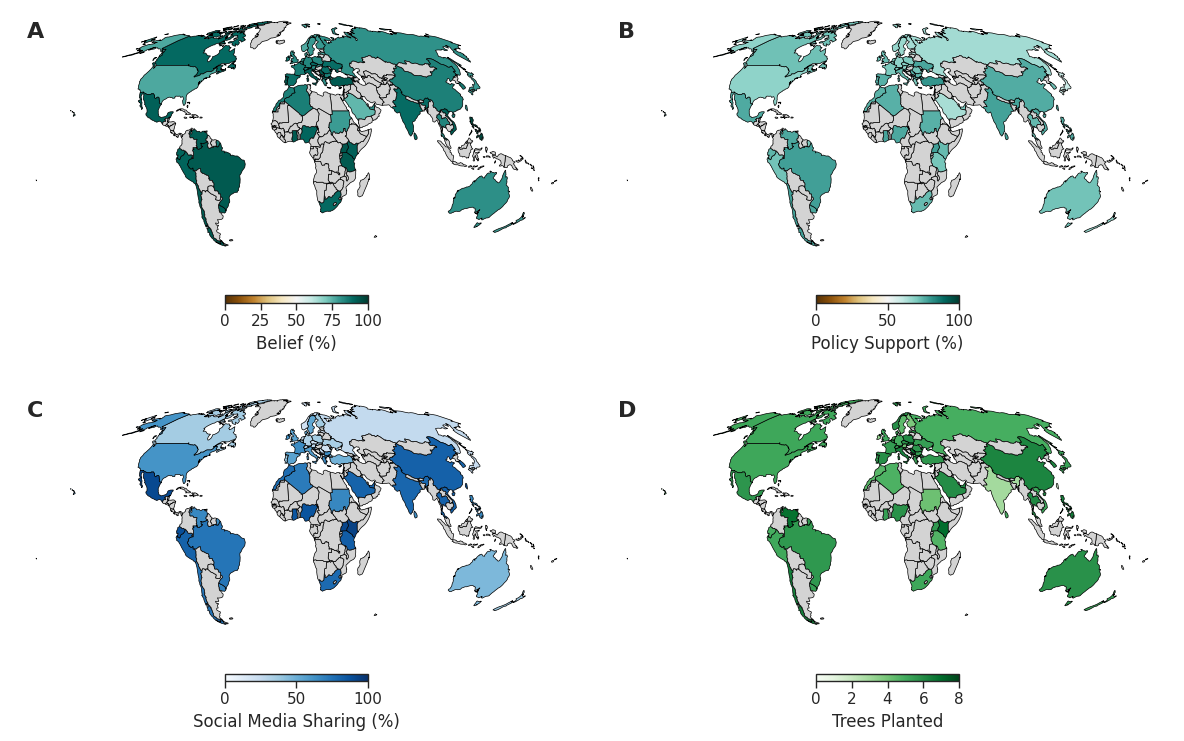

In [93]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from src.plots import plot_country_forest

# create a gridobjects
# create objects
fig = plt.figure(figsize=(12,8))
gs = GridSpec(2,2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Define the CartoPy CRS object.
crs = ccrs.Mollweide()



strip_excess = np.vectorize(lambda x: x[8:-1])
world_belief_summary = az.summary(country_plot_data)
world_belief_summary['name'] = strip_excess(world_belief_summary.index.values)
world_belief_summary = fix_df_countries(world_belief_summary)
                                
belief_world = pd.merge(world, world_belief_summary, left_on='name', 
                            right_on='name', how='left')
belief_world = belief_world.to_crs(crs)


temp = belief_world.plot(
    column="mean",
    legend=True,
    legend_kwds={'label': "Belief (%)",
                    'shrink': 0.25,  
                    'aspect': 20,
                    'location': 'bottom',
                    'ticks': [0, 25, 50, 75, 100],
                    'pad': 0.1},
    ax = ax1,
    missing_kwds={
        "color": "lightgrey",
        "label": "Missing values",
    }, vmax=100, vmin=0, 
    cmap='BrBG',
    edgecolor='black',
    linewidth=0.5,
    zorder=1
)

temp.set_axis_off()

world_data_policy = az.summary(policy_country)
strip_excess = np.vectorize(lambda x: x[2:-1])

world_data_policy['name'] = strip_excess(world_data_policy.index)
world_data_policy = fix_df_countries(world_data_policy)
policy_world = pd.merge(world, world_data_policy, left_on='name', 
                            right_on='name', how='left')

policy_world = policy_world.to_crs(crs)

temp = policy_world.plot(
    column="mean",
    legend=True,
    legend_kwds={'label': "Policy Support (%)",
                    'shrink': 0.25,  
                    'aspect': 20,
                    'location': 'bottom',
                    'pad': 0.1},
    ax = ax2,
    missing_kwds={
        "color": "lightgrey",
        "label": "Missing values",
    }, vmax=100, vmin=0, 
    cmap='BrBG',
    edgecolor='black',
    linewidth=0.5,
    zorder=1

)

temp.set_axis_off()

## plot the sharing data on a map
world_share_summary = az.summary(average_share)
strip_excess = np.vectorize(lambda x: x[2:-1]) 

world_share_summary['name'] = strip_excess(world_share_summary.index)
world_share_summary = fix_df_countries(world_share_summary)
share_world = pd.merge(world, world_share_summary, left_on='name', right_on='name', how='left')

share_world = share_world.to_crs(crs)

temp = share_world.plot(
    column="mean",
    legend=True,
    legend_kwds={'label': "Social Media Sharing (%)",
                    'shrink': 0.25,  
                    'aspect': 20,
                    'location': 'bottom',
                    'pad': 0.1},
    ax = ax3,
    missing_kwds={
        "color": "lightgrey",
        "label": "Missing values",
    }, vmax=100, vmin=0, 
    cmap='Blues',
    edgecolor='black',
    linewidth=0.5,
    zorder=1

)

temp.set_axis_off()
plt.tight_layout()


world_wept_summary = az.summary(wept_plotting)
strip_excess = np.vectorize(lambda x: x[8:-1])
world_wept_summary['name'] = wept_ls
world_wept_summary = fix_df_countries(world_wept_summary)
wept_world = pd.merge(world, world_wept_summary, left_on='name', right_on='name', how='left')

temp = wept_world.plot(
    column="mean",
    legend=True,
    legend_kwds={'label': "Trees Planted",
                    'shrink': 0.25,  
                    'aspect': 20,
                    'location': 'bottom',
                    'ticks': [0, 2, 4, 6, 8],
                    'pad': 0.1},
    ax = ax4,
    missing_kwds={
        "color": "lightgrey",
        "label": "Missing values",
    }, vmax=8, vmin=0, 
    cmap='Greens',
    edgecolor='black',
    linewidth=0.5,
    zorder=1

)


temp.set_axis_off()
plt.tight_layout()
##crop the map

##add a, b, c, d labels
for ax, label in zip([ax1, ax2, ax3, ax4], ['A', 'B', 'C', 'D']):
    ax.text(0.03, 0.95, label, transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')

plt.savefig('./out/figs/manuscript/world_fig.png', dpi=300, bbox_inches='tight')



IndexError: invalid index to scalar variable.

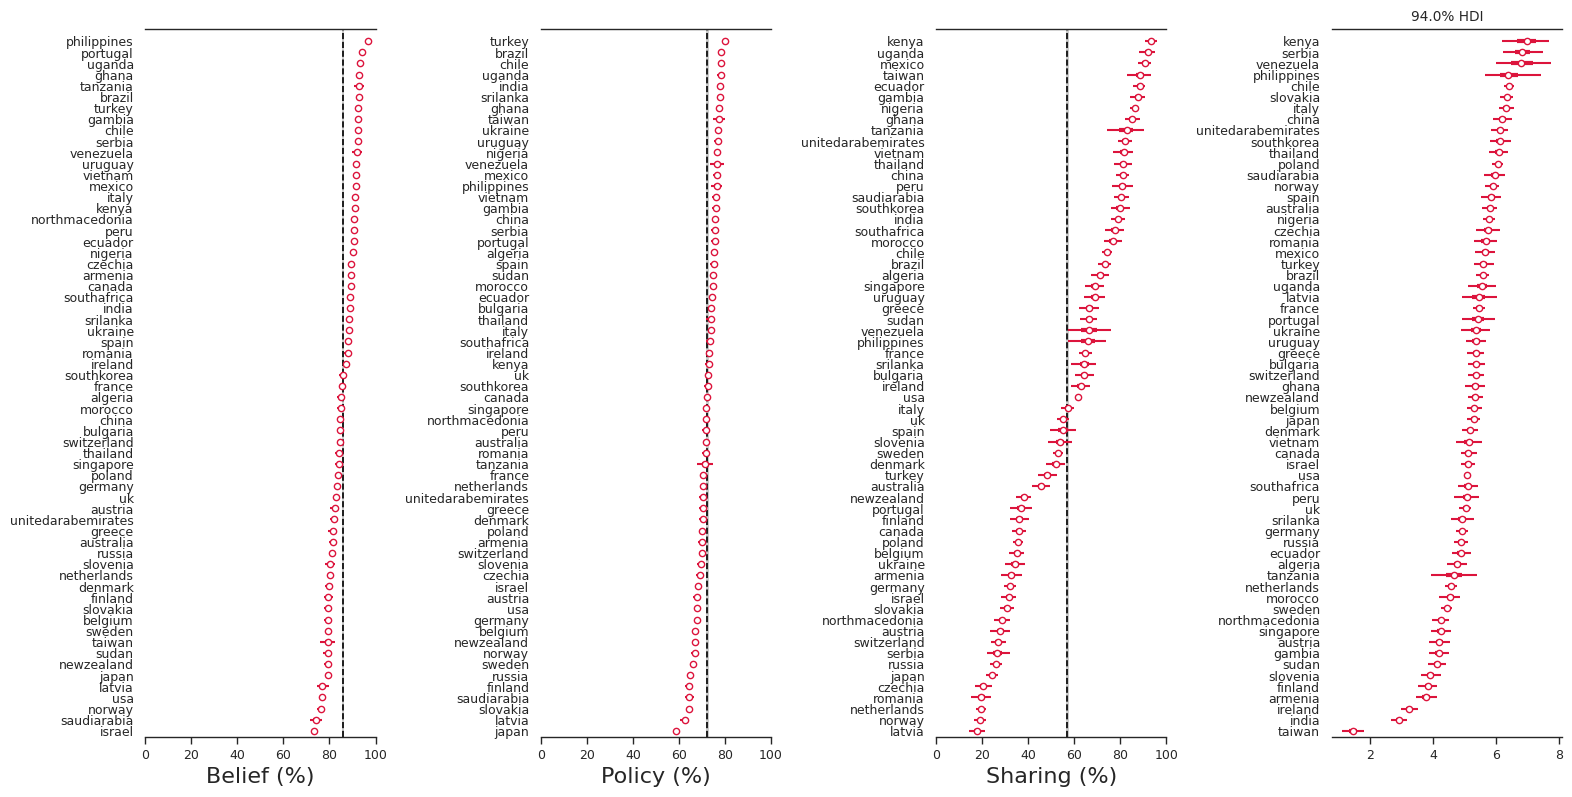

In [94]:
# import modules
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from src.plots import plot_country_forest

# create a gridobjects
fig = plt.figure(figsize=(16,8))
gs = GridSpec(1,4, figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

#Plot everything, note xlim for WEPT
plot_country_forest(country_plot_data,  belief_labels,country_mean, ax=ax1, xlabel='Belief (%)')
plot_country_forest(plot_data_policy,  labels_policy, avg_policy, ax=ax2, xlabel='Policy (%)')
plot_country_forest(average_share,  sharing_labels, average_share.mean(dim='countries') , ax=ax3, xlabel='Sharing (%)')
plot_country_forest(wept_plotting,  wept_ls, wept_mu, ax=ax4, xlabel='Trees planted', wept=True)
plt.xlim(0,8)

def relabel_country_ticks(yticks):
    #uppercase first letter
    yticks = [item.capitalize() for item in yticks]
    #replace country names
    yticks = [item.replace('Russian Federation', 'Russia') for item in yticks]
    replace_dict =  {'Russian Federation':'Russia',
                    'unitedarabemirates':'United Arab Emirates',
                    'uk':'United Kingdom',
                    'southkorea':'South Korea',
                    'northmacedonia':'North Macedonia',
                    'southafrica':'South Africa',
                    'saudiarabia': 'Saudi Arabia',
                    'srilanka': 'Sri Lanka',
                    'newzealand': 'New Zealand',
                    'usa': 'USA'}
    yticks = [replace_dict[item.lower().strip()] if item.lower().strip() in replace_dict.keys() else item for item in yticks] 
    return yticks

plt.xticks([0, 2,4,6,8])

#Add back the borders
for ax in [ax1, ax2, ax3, ax4]:
    #Get the text labels from the y axis
    yticks = ax.get_yticklabels()
    ylabels = [item.get_text() for item in yticks]
    adjusted_y_labels = relabel_country_ticks(ylabels)
    print(adjusted_y_labels)
    ax.set_yticklabels(adjusted_y_labels)
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth(1)  

#Add A-B-C-D labels
for ax in [ax1, ax2, ax3, ax4]:
    ax.text(-0.1, 1.025, chr(ord('@') + ax.get_subplotspec().num1 + 1), 
            transform=ax.transAxes, 
            size=20, weight='bold')
    
#Save the figure
plt.savefig('./out/figs/manuscript/fig_2.pdf', bbox_inches='tight', transparent=False)
plt.savefig('./out/figs/manuscript/fig_2.png', dpi=300, bbox_inches='tight', transparent=False)

## Save Tables

In [63]:
#Install xlsxwriter if you don't have it
!pip install xlsxwriter

In [64]:
#Open a writer 
writer = pd.ExcelWriter('./out/tables/supplmentary_tables.xlsx', engine='xlsxwriter')

#Belief by Country
summary_country = az.summary(country_plot_data, stat_funcs=func_dict).sort_values('mean', ascending=False)
summary_country.index = belief_labels
summary_slim_b = summary_country[summary_country.columns[[0,1,10,11,12, 13, 14,15,16]]]
summary_slim_b.to_latex('./out/tables/belief_country_summary.tex')
summary_slim_b.to_excel(writer, sheet_name='Belief_by_country', startrow=1)

#Policy By Country
summary_country_policy = az.summary(plot_data_policy, stat_funcs=func_dict).sort_values('mean', ascending=False)
summary_country_policy.index = labels_policy
summary_slim_p = summary_country_policy[summary_country_policy.columns[[0,1,10,11,12, 13, 14,15,16]]]
summary_slim_p.to_latex('./out/tables/policy_country_summary.tex')
summary_slim_p.to_excel(writer, sheet_name='Policy_by_country', startrow=1)



#Sharing By Country
summary_country_share = az.summary(average_share, stat_funcs=func_dict).sort_values('mean', ascending=False)
summary_country_share.index = sharing_labels
summary_slim_s = summary_country_share[summary_country_share.columns[[0,1,10,11,12, 13, 14,15,16]]]
summary_slim_s.to_latex('./out/tables/share_country_summary.tex')
summary_slim_s.to_excel(writer, sheet_name='Sharing_by_country', startrow=1)


#WEPT By Country
summary_country_wept = az.summary(wept_plotting, stat_funcs=func_dict).sort_values('mean', ascending=False)
summary_country_wept.index = wept_ls
summary_slim_w = summary_country_wept[summary_country_wept.columns[[0,1,10,11,12, 13, 14,15,16]]]
summary_slim_w.to_latex('./out/tables/WEPT_country_summary.tex')
summary_slim_w.head()
summary_slim_w.to_excel(writer, sheet_name='WEPT_by_Country', startrow=1)

#Leaving the writer open for later


/tmp/ipykernel_135730/306662832.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  summary_slim_b.to_latex('./out/tables/belief_country_summary.tex')
/tmp/ipykernel_135730/306662832.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  summary_slim_p.to_latex('./out/tables/policy_country_summary.tex')
/tmp/ipykernel_135730/306662832.py:24: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formattin

# Average Treatment Effects

## Calculate ATE

In [ ]:
def get_ate(idata, sim_model):
    with sim_model:
        x_sim = np.linspace(x_sim_low, x_sim_high, res)
        x_sim = logit(x_sim)
        plt.sca(ax)
        pm.set_data({country_name:np.repeat(0, res), 
            treatment_name:np.repeat(control_idx, res), 
            'bool_country':np.repeat(0, res),
            'sim_belief':x_sim})
        ppc = pm.sample_posterior_predictive(idata_sim, var_names=[var_name])
    return ppc

get_ate()    

In [77]:
#Belief
#Calculate the country average and add it to each treatment intercept
#Then add the treatment effect of intercept multiplied by the study average belief. 
ATE = 100*expit(idata_belief.posterior['country'].mean() + idata_belief.posterior['u_t'].sel({'effect':'Intercept'}) + \
idata_belief.posterior['u_t'].sel({'effect':'Slope'}) * idata_belief.posterior['country'].mean())

#Subtract the posterior for control. 
ATE = ATE - ATE.sel({'treatments':'aaControl'})
sorted_ate = az.summary(ATE).sort_values('mean', ascending=False) 

#Function to remove unnecessary characters from the labels 
strip_excess = np.vectorize(lambda x: x[2:-1])
all_ts = strip_excess(sorted_ate.index.values)
#Remove the control treatment (it's just 0's)
belief_ts = np.delete(all_ts, np.where(all_ts=='aaControl'))
ate_belief_plot_data = ATE.sel({'treatments':belief_ts})

#Policy 
#Calculate the average policy support at the study average level of belief. 
treatment_policy =  idata_policy.posterior['Alpha']  + \
            idata_policy.posterior['u_t'][:,:,0,:] + idata_policy.posterior['u_t'][:,:,0,:] + \
            (idata_policy.posterior['Beta'] + idata_policy.posterior['u_t'][:,:,0,:] + idata_policy.posterior['u_t'][:,:,0,:]) *idata_belief.posterior['country'].mean() 

#Convert to percentage
treatment_policy = 100* (expit(treatment_policy) * (1-idata_policy.posterior['theta']) + \
                        idata_policy.posterior['theta'] * expit(idata_policy.posterior['tau_offset'] * treatment_policy + \
                              treatment_policy))
ATE = treatment_policy
az.summary(ATE)

#Subtract the posterior for control, and sort by the mean, 
# then remove the control treatment, and select the rest with the sorted labels.
ATE = ATE - ATE.sel({'treatments':'Control'})
sorted_ate = az.summary(ATE).sort_values('mean', ascending=False) 
strip_excess = np.vectorize(lambda x: x[2:-1])
all_ts = strip_excess(sorted_ate.index.values)
labels_policy = np.delete(all_ts, np.where(all_ts=='Control'))
ate_policy_plot_data = ATE.sel({'treatments':labels_policy})


#Sharing 
control_idx = np.where(share_idata.posterior['u_t'].coords['treatments'].values=='Control')[0]
#Calculate for the control
control_share = 100*expit(share_idata.posterior['Alpha'] + \
                    share_idata.posterior['Beta'] * logit(average_study_belief/100) + \
                        share_idata.posterior['u_t'][:, :, control_idx, 0] + \
                            share_idata.posterior['u_t'][:, :, control_idx, 1] * logit(average_study_belief/100)).data
                            
#calculate for the rest. 
labels = np.array([value for value in share_idata.posterior['u_t'].coords['treatments'].values if value != 'Control'])
treatment_share = 100*expit(share_idata.posterior['Alpha'] + \
                    share_idata.posterior['Beta'] * logit(average_study_belief/100) + \
                        share_idata.posterior['u_t'][:, :, 0,:] + \
                            share_idata.posterior['u_t'][:, :, 1,:] * logit(average_study_belief/100))   - control_share

#Function to remove unnecessary characters from the labels
strip_excess = np.vectorize(lambda x: x[2:-1])

#labels, summarize and sort, save, etc.. 
share_ATE_idata = treatment_share.sel({'treatments':labels})
share_ATE_summary = az.summary(share_ATE_idata).sort_values('mean', ascending=False)
share_ls_ATE = strip_excess(share_ATE_summary.index.values)
share_avg_ATE = share_ATE_idata.sel({'treatments':share_ls_ATE})


#WEPT
strip_excess = np.vectorize(lambda x: x[2:-4])
wpost = wept_idata.posterior
#Unlike country, we just calculate the expectation directly. 
#I thought it would be a nightmare but it's not so bad. 
mu1 = wpost['Intercept_geom'] + wpost['Beta_geom'] * logit(average_study_belief/100) + \
    wpost['treatment_intercept_geom'] + wpost['treatment_beta_geom'] * logit(average_study_belief/100)
mu2 = wpost['Intercept_theta'] + wpost['Beta_theta'] * logit(average_study_belief/100) + \
    wpost['treatment_intercept_theta'] + wpost['treatment_beta_theta'] * logit(average_study_belief/100)
theta = expit(mu1)
#Expectation of the geometric part of the model. 
sim_p = 1 / (1 + expit(mu2) * (wept_idata.constant_data.data_vars['upper']-1))
#Mixture 
avg = (1-theta) * (1/sim_p-1) + theta * (wept_idata.constant_data.data_vars['upper']-1)
wept_avg = avg

#Subtract the posterior for control, and sort by the mean,grab labels, etc... 
avg = avg-avg.sel({'treatments':'Control'})
ls = strip_excess(az.summary(avg).sort_values('mean', ascending=False).index)
wept_ls_ATE = [l for l in ls if l != 'Control']
wept_avg_ATE = avg.sel({'treatments':wept_ls_ATE})



/home/jbb2191/.local/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/jbb2191/.local/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


KeyError: "not all values found in index 'treatments'"

## Plotting

In [ ]:
from src.plots import treatment_pal

In [ ]:
def plot_ATE_data(idata, ls, ax, xlabel='Sharing(%)', xlim=(-15,15), xticks=[-15,-10,-5,0,5,10,15], color='green'):
    plt.sca(ax)
    treatments = idata.coords["treatments"].values
    az.plot_forest( [idata.sel({"treatments": t}) for t in treatments], linewidth=4, 
                   textsize=10, markersize=10, combined=True, colors=color, legend=False, ax=ax)
    locs, labels =plt.yticks()
    ax.set_facecolor('white')
    ylim = plt.ylim()
    plt.yticks(locs,ls[::-1])
    plt.title('')
    plt.xlim(xlim)
    plt.fill_between(plt.xlim(),[100, 100],color='white', zorder=1)
    plt.plot([0, 0],plt.ylim(), '--', color='k', zorder=1)
    plt.xticks(xticks)
    plt.xlabel(xlabel)
    plt.ylim(locs[0]-locs[-1]/24, locs[-1]+locs[-1]/24)


In [78]:
df['condName'].unique()

array(['CollectAction', 'Control', 'Letter2Future', 'SciConsens',
       'PluralIgnorance', 'DynamicNorm', 'PsychDistance', 'SystemJust',
       'FutureSelfCont', 'Identity-Social-Norms-Intervention',
       'NegativeEmotions', 'BindingMoral', nan], dtype=object)

Control mean: Beleif
<xarray.DataArray ()>
array(86.80624976)
Coordinates:
    treatments  <U9 'aaControl'
<xarray.DataArray (quantile: 2)>
array([86.80624976, 86.80624976])
Coordinates:
  * quantile  (quantile) float64 0.03 0.97
--------------------
Control mean: policy support
<xarray.DataArray ()>
array(69.77287879)
Coordinates:
    effect      <U9 'intercept'
    treatments  <U7 'Control'
<xarray.DataArray (quantile: 2)>
array([69.77287879, 69.77287879])
Coordinates:
  * quantile  (quantile) float64 0.03 0.97
--------------------
['Letter2Future, philippines' 'Letter2Future, armenia'
 'Letter2Future, northmacedonia' 'Letter2Future, peru'
 'Letter2Future, kenya' 'Letter2Future, srilanka' 'Letter2Future, ukraine'
 'Letter2Future, uruguay' 'Letter2Future, india'
 'Letter2Future, venezuela' 'Letter2Future, serbia' 'Letter2Future, ghana'
 'Letter2Future, chile' 'Letter2Future, algeria' 'Letter2Future, nigeria'
 'Letter2Future, gambia' 'Letter2Future, russia' 'Letter2Future, turkey'
 'Le

KeyError: 'Letter2Future, philippines'

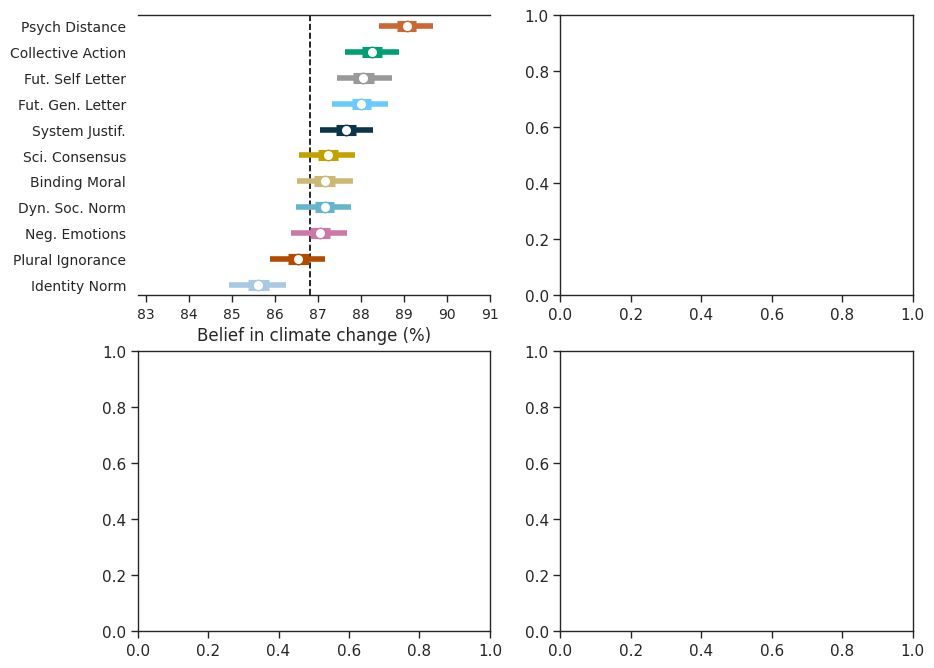

In [79]:


#from src.plots import plot_ATE_data
from src.plots import treatment_pal
# create objects
fig = plt.figure(figsize=(10,8))

gs = GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

rename_dict = {'PsychDistance':'Psych Distance', 
                'PluralIgnorance': 'Plural Ignorance', 
                'CollectAction': 'Collective Action', 
                'SystemJust': 'System Justif.',
                'Letter2Future': 'Fut. Gen. Letter',
                'FutureSelfCont': 'Fut. Self Letter',
                'DynamicNorm': 'Dyn. Soc. Norm',
                'NegativeEmotions': 'Neg. Emotions',
                'SciConsens': 'Sci. Consensus',
                'BindingMoral': 'Binding Moral',
                'aaControl': 'Control',
                'Identity-Social-Norms-Intervention': 'Identity Norm'}


relabel = lambda x: [rename_dict[item] for item in x]

#Plot everything 
ATE = 100*expit(idata_belief.posterior['country'].mean() + idata_belief.posterior['u_t'].sel({'effect':'Intercept'}) + \
idata_belief.posterior['u_t'].sel({'effect':'Slope'}) * idata_belief.posterior['country'].mean())
mu = ATE.sel({'treatments':'aaControl'}).mean()
colors = [treatment_pal[item] for item in belief_ts]
plot_ATE_data(ate_belief_plot_data+mu, relabel(belief_ts), ax1, xlim=(mu-4, mu+4),
              xlabel='Belief in climate change (%)',
              xticks=np.linspace(np.round(mu)-4, np.round(mu)+4, 9), color=colors)
ax1.plot([mu, mu],plt.ylim(), '--', color='k', zorder=1)
print('Control mean: Beleif')
print(np.mean(mu))
print(mu.quantile([0.03, 0.97]))
print('-'*20)


#Policy 
#Calculate the average policy support at the study average level of belief. 
#Calculate the average policy support at the study average level of belief. 
treatment_policy =  idata_policy.posterior['Alpha']  + \
            idata_policy.posterior['u_t'][:,:,0,:] + idata_policy.posterior['u_t'][:,:,0,:] + \
            (idata_policy.posterior['Beta'] + idata_policy.posterior['u_t'][:,:,0,:] + idata_policy.posterior['u_t'][:,:,0,:]) *idata_belief.posterior['country'].mean() 

#Convert to percentage
treatment_policy = 100* (expit(treatment_policy) * (1-idata_policy.posterior['theta']) + \
                        idata_policy.posterior['theta'] * expit(idata_policy.posterior['tau_offset'] * treatment_policy + \
                              treatment_policy))
ATE = treatment_policy
mu = ATE.sel({'treatments':'Control'}).mean()
print('Control mean: policy support')
print(mu.mean())
print(mu.quantile([0.03, 0.97]))
print('-'*20)
print(labels_policy)
colors = [treatment_pal[item] for item in labels_policy]
plot_ATE_data(ate_policy_plot_data+mu, relabel(labels_policy), ax2, xlim=(mu-8, mu+8),
              xlabel='Policy support (%)',
              xticks=np.linspace(np.round(mu)-4, np.round(mu)+4, 9), color=colors)
ax2.plot([mu, mu],plt.ylim(), '--', color='k', zorder=1)



mu = control_share.mean()
colors = [treatment_pal[item] for item in share_ls_ATE]
plot_ATE_data(share_avg_ATE+mu, relabel(share_ls_ATE), ax3,xlim=(mu-15, mu+15),
              xticks=np.linspace(np.round(mu)-15, np.round(mu)+15, 7),
              xlabel='Change in sharing(%)',color=colors)
ax3.plot([mu, mu],plt.ylim(), '--', color='k', zorder=1)

mu = control_share
print('Control mean: Sharing')
print(np.mean(mu))
print(np.quantile(mu, [0.03, 0.97]))
print('-'*20)

avg = (1-theta) * (1/sim_p) + theta * wept_idata.constant_data.data_vars['upper']-1
mu = avg.sel({'treatments':'Control'}).mean()
colors = [treatment_pal[item] for item in wept_ls_ATE]
plot_ATE_data(wept_avg_ATE+mu, relabel(wept_ls_ATE), ax4, xlim=(mu-1,mu+1),
              xlabel='Change in trees planted', xticks=np.linspace(np.round(mu)-1, np.round(mu)+1, 5),
              color=colors)
ax4.plot([mu, mu],plt.ylim(), '--', color='k', zorder=1)

print('Control mean: WEPT')
print(avg.sel({'treatments':'Control'}).mean())
print(avg.sel({'treatments':'Control'}).quantile([0.03, 0.97]))
print('-'*20)

#Add A-B-C-D labels

for ax in [ax1, ax2, ax3, ax4]:
    ax.text(-0.3, 1.025, chr(ord('@') + ax.get_subplotspec().num1 + 1), 
            transform=ax.transAxes, 
            size=20, weight='bold')

plt.tight_layout()
plt.savefig('./out/figs/manuscript/fig_3.pdf', bbox_inches='tight', transparent=False)
plt.savefig('./out/figs/manuscript/fig_3.png', dpi=300, bbox_inches='tight', transparent=False)

In [ ]:
df.groupby(['condName'])['BELEIFcc'].mean().sort_values(ascending=False)

NameError: name 'df' is not defined

In [ ]:
## Tables for ATE

summary_ate = az.summary(ate_belief_plot_data, stat_funcs=func_dict).sort_values('mean', ascending=False)
summary_ate.index = relabel(belief_ts)
summary_slim = summary_ate[summary_ate.columns[[0,1,10,11,12, 13, 14,15,16]]]
summary_slim.to_latex('./out/tables/belief_ATE_summary.tex')
summary_slim
summary_slim.to_excel(writer, sheet_name='Belief_ATE', startrow=1)


#Policy
summary_ate = az.summary(ate_policy_plot_data, stat_funcs=func_dict)
summary_ate.index = labels_policy
summary_slim = summary_ate[summary_ate.columns[[0,1,10,11,12, 13, 14,15,16]]]
summary_slim.to_latex('./out/tables/policy_ATE_summary.tex')
summary_slim.to_excel(writer, sheet_name='Policy_ATE', startrow=1)

#Sharing
summary_ate = az.summary(share_avg_ATE, stat_funcs=func_dict).sort_values('mean', ascending=False)
summary_ate.index = relabel(share_ls_ATE)
summary_slim = summary_ate[summary_ate.columns[[0,1,10,11,12, 13, 14,15,16]]]
summary_slim.to_latex('./out/tables/share_ATE_summary.tex')
summary_slim.to_excel(writer, sheet_name='Sharing_ATE', startrow=1)

#WEPT
summary_ate = az.summary(wept_avg_ATE, stat_funcs=func_dict).sort_values('mean', ascending=False)
summary_ate.index = relabel(wept_ls_ATE)
summary_slim = summary_ate[summary_ate.columns[[0,1,10,11,12, 13, 14,15,16]]]
summary_slim.to_latex('./out/tables/wept_ATE_summary.tex')
summary_slim.to_excel(writer, sheet_name='WEPT_ATE', startrow=1)

writer.close()

/home/joseph/anaconda3/envs/mlc/lib/python3.10/site-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


# Heterogenous Treatment Effects by Belief

In [ ]:
df.groupby(['condName'])['WEPTcc'].mean()

NameError: name 'df' is not defined

In [ ]:
from src.plots import plot_by_belief
# create objects
fig = plt.figure(figsize=(10,8))

gs = GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])


#Belief
res = 100
var_name = 'y_sim_fixed_belief'
sim_model = belief_model
unplotted = []
idata_sim = idata_belief
treatments = idata_belief.posterior['u_t'].coords['treatments'].data
control_idx = 0
avg = 100*country_mean.mean().data
plot_by_belief(sim_model, idata_sim, var_name, treatments, 
                control_idx,avg=country_mean.mean().data, 
                ax=ax1, ylabel='Change in belief (%)',relabel=relabel, convert_func = expit)

#Policy 
var_name = 'mu_pred'
sim_model = policy_model
unplotted = []
idata_sim = idata_policy
treatments = idata_policy.posterior['u_t'].coords['treatments'].data
control_idx = np.where(treatments=='Control')[0][0]
plot_by_belief(sim_model, idata_sim, var_name, treatments, control_idx,avg=country_mean.mean().data,ylim=(-10,10),
               country_name='country_pred', 
               treatment_name='treatment_pred', ax=ax2, ylabel='Change in policy support (%)',relabel=relabel, convert_func = expit)
#Sharing

var_name = 'sim_mu'
sim_model = share_model
unplotted = []
idata_sim = share_idata
treatments = share_idata.posterior['u_t'].coords['treatments'].data
control_idx = np.where(treatments=='Control')[0]

plot_by_belief(sim_model, idata_sim, var_name, treatments, control_idx, avg=country_mean.mean().data, ax=ax3,
               ylim=(-15, 15), ylabel='Change in sharing (%)', relabel=relabel, convert_func = expit)


#WEPT 
var_name = 'sim_mu'
sim_model = wept_model
unplotted = []
idata_sim = wept_idata
treatments = wept_idata.posterior['u_t'].coords['treatments'].data
control_idx = np.where(treatments=='Control')[0]
plot_by_belief(sim_model, idata_sim, var_name, treatments, control_idx, avg=country_mean.mean().data, res=res, ax=ax4, 
               ylim=(-1, 1), ylabel='Change in trees planted',  relabel=relabel,mult=1)

#Add A-B-C-D labels
for ax in [ax1, ax2, ax3, ax4]:
    ax.text(-0.1, 1.05, chr(ord('@') + ax.get_subplotspec().num1 + 1), 
            transform=ax.transAxes, 
            
            size=20, weight='bold')


plt.tight_layout()

plt.savefig('./out/figs/manuscript/fig_4.pdf', bbox_inches='tight', transparent=False)
plt.savefig('./out/figs/manuscript/fig_4.png', dpi=300, bbox_inches='tight', transparent=False)


NameError: name 'plt' is not defined

# Additional Analyses 

In [ ]:

print('Averge belief') 
print(country_mean.mean())
print('Belief Credible Region')
print('Lower: ', country_mean.quantile(0.03).data)
print('Upper: ', country_mean.quantile(0.97).data)
print(df['BELIEFcc'].mean())

#Average Policy Support
print('Averge policy support')
print(plot_data_policy.mean(dim='countries').mean().data)
print('Policy Support Credible Region')
print('Lower: ', plot_data_policy.mean(dim='countries').quantile(0.03).data)
print('Upper: ', plot_data_policy.mean(dim='countries').quantile(0.97).data)
print(df['POLICYcc'].mean())

#Average Sharing
print('Averge sharing')
print(average_share.mean())
print('Sharing Credible Region')
print('Lower: ', average_share.mean(dim='countries').quantile(0.03).data)
print('Upper: ', average_share.mean(dim='countries').quantile(0.97).data)
print(df['SHAREcc'].mean())

#Average WEPT
print('Averge WEPT')
print(wept_plotting.mean())
print('WEPT Credible Region')
print('Lower: ', wept_plotting.mean(dim='sim_mu_dim_2').quantile(0.03).data)
print('Upper: ', wept_plotting.mean(dim='sim_mu_dim_2').quantile(0.97).data)
print(df['WEPTcc'].mean())
#Average WEPT
print('Averge WEPT')
print(wept_plotting.mean())
print('WEPT Credible Region')
print('Lower: ', wept_plotting.mean(dim='sim_mu_dim_2').quantile(0.03).data)
print('Upper: ', wept_plotting.mean(dim='sim_mu_dim_2').quantile(0.97).data)

#Total Trees Planted
print('Total Trees Planted')
print(df['WEPTcc'].sum())

print('All conditions trees planted')
print((df['WEPTcc']==8).mean())

print('Control Condition Trees Planted')
print((df[df['condName']=='Control']['WEPTcc']==8).mean())




Averge belief
<xarray.DataArray ()>
array(83.28740921)
Belief Credible Region
Lower:  82.87177953026807
Upper:  83.61986820478664
78.66019223128878
Averge policy support
69.04599617746507
Policy Support Credible Region
Lower:  68.31065315176573
Upper:  69.7452634144005
69.58400864953468
Averge sharing
<xarray.DataArray 'x' ()>
array(58.92647643)
Sharing Credible Region
Lower:  57.01767107875846
Upper:  60.81676816652253
0.5266350474288567
Averge WEPT
<xarray.DataArray 'sim_mu' ()>
array(5.42493286)
WEPT Credible Region
Lower:  5.327574749767754
Upper:  5.534046943482837
4.822240111237147
Averge WEPT
<xarray.DataArray 'sim_mu' ()>
array(5.42493286)
WEPT Credible Region
Lower:  5.327574749767754
Upper:  5.534046943482837
Total Trees Planted
263574
All conditions trees planted
0.5042994621098467
Control Condition Trees Planted
0.5257464301168325


<ipython-input-50-c8f6d2b0d3f1>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = df.groupby('condName').median()['Intervention_Timer']


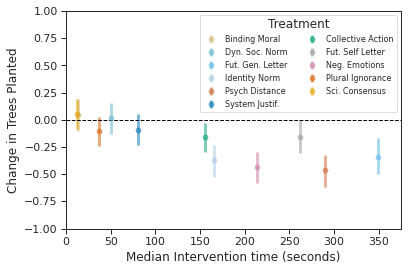

In [ ]:
from src.plots import treatment_pal
import itertools
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])


grouped = df.groupby('condName').median()['Intervention_Timer']


c = [treatment_pal[item] for item in grouped.index if item !=  'Control']
labels = relabel([item for item in grouped.index if item !=  'Control'])
##Plot errorbars 
avg = wept_avg_ATE.mean(dim=('chain', 'draw'))
mu = avg.sel({'treatments':[item for item in grouped.index if item!='Control']}).data
lower = wept_avg_ATE.quantile(.03, dim=('chain', 'draw'))
lower = lower.sel({'treatments':[item for item in grouped.index if item!='Control']}).data

upper = wept_avg_ATE.quantile(.97, dim=('chain', 'draw'))
upper = upper.sel({'treatments':[item for item in grouped.index if item!='Control']}).data

##Plot errorbars
for idx in range(11):
    plt.errorbar(grouped[grouped.index!='Control'].values.ravel()[idx], mu.ravel()[idx], 
                yerr=np.array([np.abs(mu-lower), np.abs(mu-upper)]).reshape(2,11)[:,idx].reshape(2,1), fmt='o',
                    elinewidth=3, capsize=0, color=c[idx], label=labels[idx],alpha=.5)

handles, labels = plt.gca().get_legend_handles_labels()
    
plt.legend(flip(handles, 2), flip(labels, 2),loc=1, ncol=2,title='Treatment',prop={'size': 8})
##Horizontal line at 0
plt.plot([0, 375], [0, 0], color='black', linestyle='--', linewidth=1)

plt.ylabel('Change in Trees Planted')
plt.xlabel('Median Intervention time (seconds)')
plt.ylim(-1,1)
plt.xlim(0, 375)

plt.savefig('./out/figs/manuscript/WEPT_SI.png', bbox_inches='tight', transparent=False)
plt.savefig('./out/figs/manuscript/WEPT_SI.pdf', bbox_inches='tight', transparent=False)